In [104]:
using Pkg;
Pkg.activate(".");

  Activating project at `~/optimal_control_presentation`


In [103]:
using DifferentialEquations, StaticArrays
using Optimization, OptimizationNLopt, OptimizationBBO, OptimizationOptimJL
using Plots

In [85]:
function get_min_idx_geq(x_vec, x)
    for (i, xᵢ) in enumerate(x_vec)
        if xᵢ ≥ x - eps(x)
            if i == 1
                return (1, 2)
            else
                return (i - 1, i)
            end
        end
    end
    # throw(BoundsError("x falls outside of x_vec"))
    v = last(x_vec)
    @error "x falls outside of x_vec, x = $x, last(x_vec) = $v"
    return nothing
end

function interpolate_increasing_arrays(x_vec, y_vec, x)
    (i, j) = get_min_idx_geq(x_vec, x)
    y = y_vec[i] + (x - x_vec[i]) * (y_vec[j] - y_vec[i]) / (x_vec[j] - x_vec[i])
    return y
end

interpolate_increasing_arrays (generic function with 1 method)

In [86]:
function f(X, p, t)
    x, y, v = X[:]
    g, tf, u_vec... = @view p[:]
    u = interpolate_increasing_arrays(range(0, 1.0, length(u_vec)), u_vec, t)

    return @SVector [
        v * sin(u) * tf, # dx
        -v * cos(u) * tf, # dy
        g * cos(u) * tf, # du
    ]
end

f (generic function with 1 method)

In [87]:
function evaluate_cost(X;
    n=0,
    x0=@SVector [0.0, 0.0, 0.0]
)
    tf, u... = X

    tspan = (0.0, 1.0)
    p = [9.81, tf, u...]

    prob = ODEProblem(f, x0, tspan, p)

    sol = solve(prob,
        save_idxs=[1, 2],
        save_on=false,
        save_end=true,
    )
    return tf + n*sum(exp.((sol[end] - [2, -2]) .^ 2))
end

function solve_system(X;
    x0=@SVector [0.0, 0.0, 0.0]
)
    tf, u... = X

    tspan = (0.0, 1.0)
    p = [9.81, tf, u...]

    prob = ODEProblem(f, x0, tspan, p)

    sol = solve(prob)
    return sol
end

solve_system (generic function with 1 method)

In [105]:
x0 = let
    tf = 1.0
    u0 = rand(100)/10 + [0.8, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.2, 1.2, 1.2, 1.2, 1.2]
    [tf, u0...]
end
lb = let
    tf_min = 0.01
    u_min = zeros(100)
    [tf_min, u_min...]
end
ub = let
    tf_max = 10.0
    u_max = 2π * ones(100)
    [tf_max, u_max...]
end

p = []
n = 1e1
func = OptimizationFunction((X, p) -> evaluate_cost(X, n=n), Optimization.AutoForwardDiff())
prob = OptimizationProblem(func, x0, p, lb=lb, ub=ub)
sol = solve(
    prob,
    # NLopt.LD_LBFGS();
    # BBO_adaptive_de_rand_1_bin_radiuslimited(),
    Optim.ConjugateGradient(),
    g_tol = 1e-8,
)

┌ Warning: common abstol is currently not used by Fminbox{ConjugateGradient{Float64, Nothing, Optim.var"#30#32", LineSearches.InitialHagerZhang{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}, Float64, Optim.var"#49#51"}(ConjugateGradient{Float64, Nothing, Optim.var"#30#32", LineSearches.InitialHagerZhang{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}}(0.4, nothing, Optim.var"#30#32"(), LineSearches.InitialHagerZhang{Float64}
│   ψ0: Float64 0.01
│   ψ1: Float64 0.2
│   ψ2: Float64 2.0
│   ψ3: Float64 0.1
│   αmax: Float64 Inf
│   α0: Float64 1.0
│   quadstep: Bool true
│   verbose: Bool false
│ , LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
│   delta: Float64 0.1
│   sigma: Float64 0.9
│   alphamax: Float64 Inf
│   rho: Float64 5.0
│   epsilon: Float64 1.0e-6
│   gamma: Float64 0.66
│   linesearchmax: Int64 50
│   psi3: Float64 0.1
│   display: Int64 0
│   mayterminate: Base.RefValue{Bool}
│ , Flat()), NaN, 0.001, Optim.var"#49#51"())
└ @ Opt

u: 101-element Vector{Float64}:
 0.825136918930146
 0.8686299000288956
 0.06685376619713207
 0.09996810875808167
 0.08226678819037823
 0.04820310659998141
 0.15179307520943672
 0.1136595231189855
 0.1372055594038567
 0.11011241401001537
 ⋮
 1.131293986943234
 1.0816290831586146
 1.075835594424284
 1.0433960013342505
 1.2013894982629771
 1.1598228026001078
 1.1675958094619836
 1.1793728721774468
 1.1791785270026822

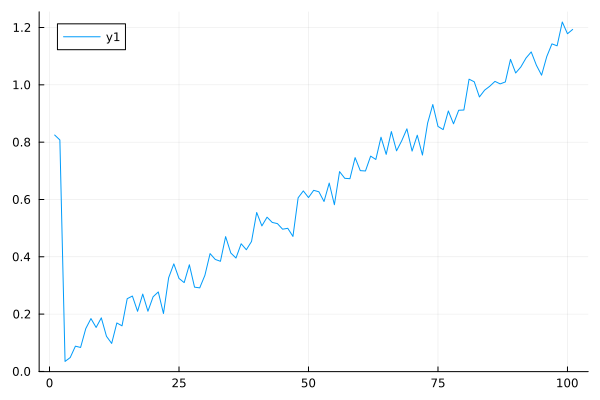

In [101]:
plot(sol.minimizer)

In [92]:
sol.minimum

20.824840911343447

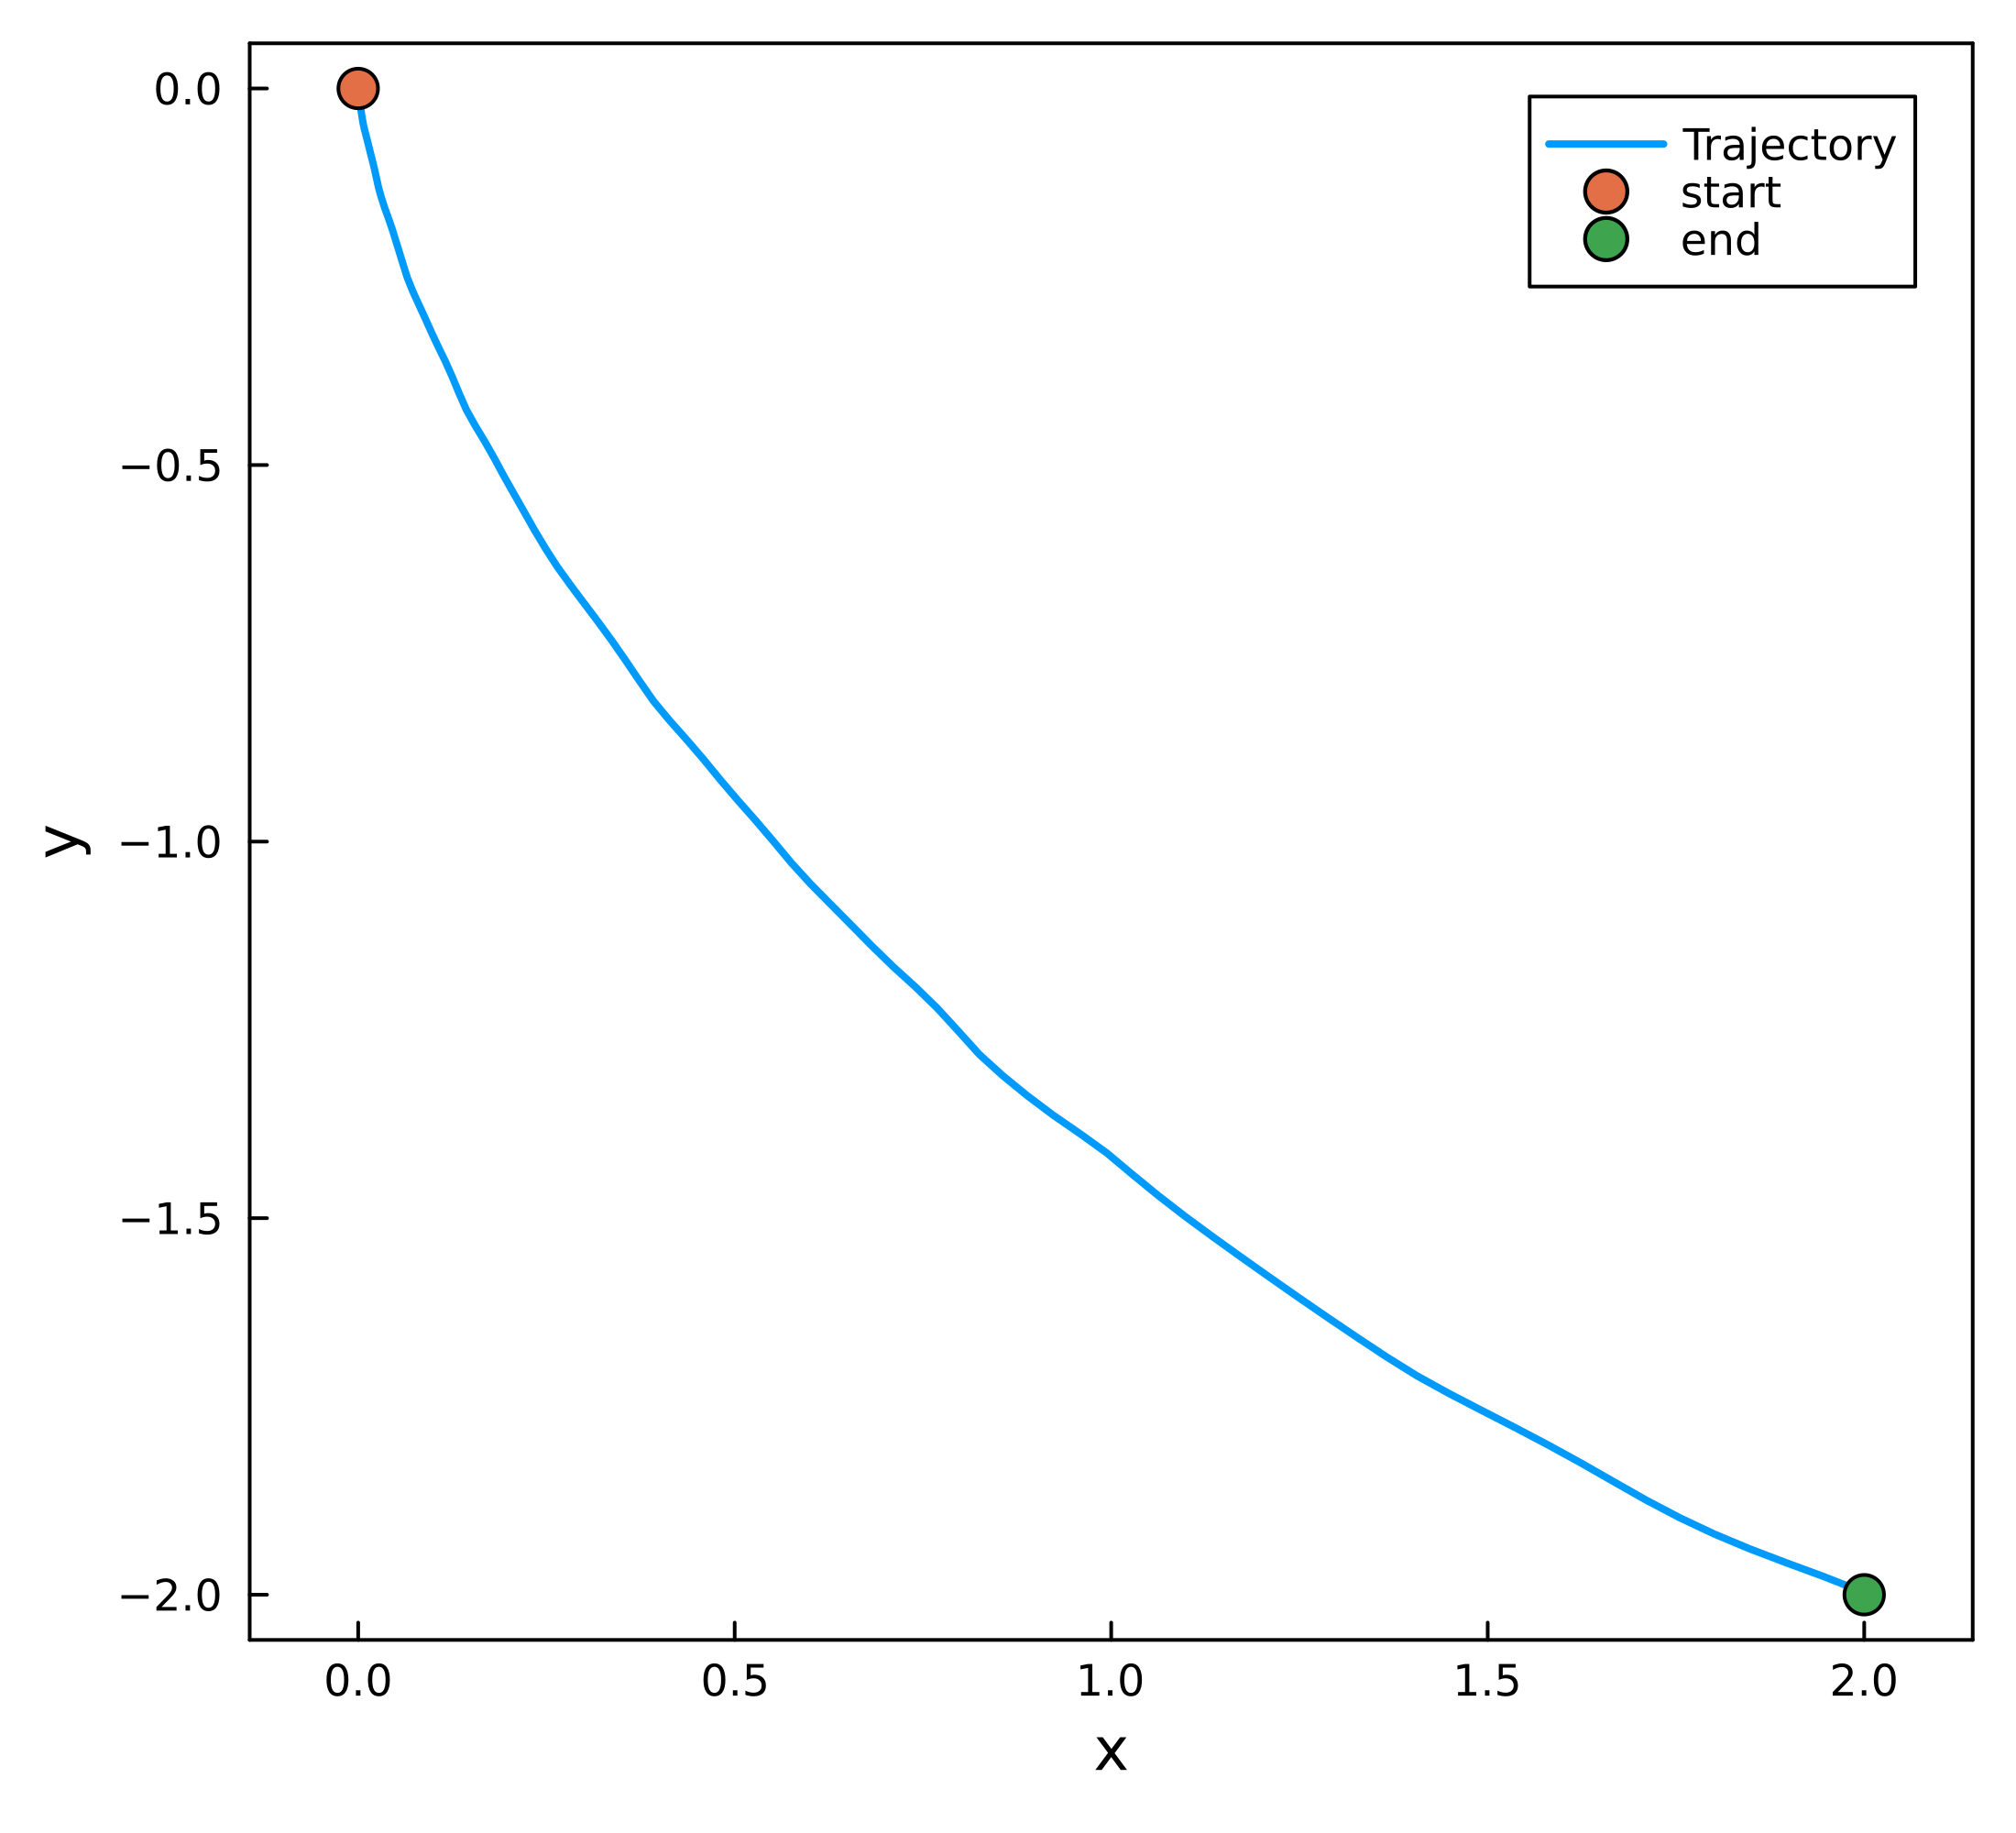

In [97]:
plt_sol = solve_system(sol.minimizer)

# k2 = 1 / (2 * 9.81 * C)
# x_true(θ) = 0.5k^2 * [
#     θ - sin(θ),
#     1 - cos(θ),
# ]

t_span = range(0, 1.0, length=100)

x = reduce(hcat, plt_sol.(t_span))[1, :]
y = reduce(hcat, plt_sol.(t_span))[2, :]
plot(
    x, y,
    xlabel="x",
    ylabel="y",
    label="Trajectory",
    lw=2,
    # legend=:none,
    box=:on,
    grid=:off,
    aspect_ratio=:equal,
    dpi=400,
    # xlims=(0, 2),
    # ylims=(0, -2),
    size=(550, 500)
)
ϵ_plt = 0.15
# xlims!(0 - ϵ_plt, 2 + ϵ_plt)
# ylims!(-2 - ϵ_plt, 0 + ϵ_plt)
ms = 6
scatter!([0], [0], label="start", markersize=ms)
scatter!([2], [-2], label="end", markersize=ms)


In [94]:
last(x), last(y)

(1.9938831823189667, -1.9988888500936253)